<a href="https://colab.research.google.com/github/amitav710/SAiDL-Spring-Assignment-2022/blob/main/SRCNN_bicubic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D
from keras import layers
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import PIL
import PIL.Image
import pathlib

In [ ]:
ds_train, info_train = tfds.load('oxford_iiit_pet', split='train', with_info=True, shuffle_files=False, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2S91D1/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2S91D1/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


,image,label
0,"[[[3, 3, 3], [5, 3, 4], [7, 5, 6], [4, 2, 3], ...",33
1,"[[[5, 9, 8], [3, 4, 0], [11, 24, 4], [36, 51, ...",12
2,"[[[44, 32, 6], [44, 34, 7], [44, 34, 7], [41, ...",9
3,"[[[108, 130, 117], [114, 133, 127], [108, 128,...",32
4,"[[[237, 228, 91], [236, 228, 93], [230, 225, 8...",33


In [ ]:
x_train=[]
for data in ds_train:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_train.append(x)
x_train = np.array(x_train)
x_train.shape

(3680, 300, 300, 3)

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train[67].shape

(300, 300, 3)

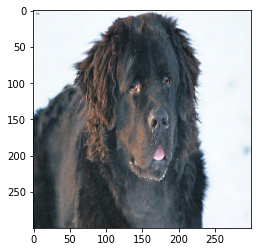

In [ ]:
plt.imshow(x_train[67])

# Converting into Low-Res Image by Downscaling and Blurring

In [ ]:
!pip install tensorflow_addons==0.15

In [ ]:
import tensorflow_addons as tfa

In [ ]:
print(tfa.__version__)

0.15.0


In [ ]:
def lowres(img:np.ndarray): #dealing with 0 to 1 float values after conversion
  img=tfa.image.gaussian_filter2d(img, filter_shape=(3,3))
  new=tf.image.resize(img, (100,100), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)
  return new/255

In [ ]:
lowres(x_train[67]).shape

TensorShape([100, 100, 3])

In [ ]:
lowres(x_train[67])

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.94030505, 0.9625272 , 0.9708061 ],
        [0.9363835 , 0.9572985 , 0.9690632 ],
        [0.9389978 , 0.9660131 , 0.9734205 ],
        ...,
        [0.9376906 , 0.95337695, 0.9681917 ],
        [0.9446623 , 0.95860565, 0.9747277 ],
        [0.9446623 , 0.96034855, 0.9729848 ]],

       [[0.9376906 , 0.9660131 , 0.97559917],
        [0.820915  , 0.843573  , 0.8553377 ],
        [0.77211326, 0.7917211 , 0.8039216 ],
        ...,
        [0.9411765 , 0.9546841 , 0.9734205 ],
        [0.9481482 , 0.96034855, 0.97952074],
        [0.9490196 , 0.96034855, 0.97952074]],

       [[0.9459695 , 0.96514165, 0.97952074],
        [0.91764706, 0.93681914, 0.95206976],
        [0.8936819 , 0.9132897 , 0.92766887],
        ...,
        [0.94248366, 0.956427  , 0.9751634 ],
        [0.9490196 , 0.96034855, 0.97864926],
        [0.9446623 , 0.9572985 , 0.9742919 ]],

       ...,

       [[0.13507625, 0.13638344, 0.14640522],
        [0.10

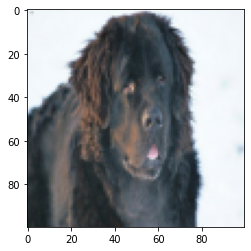

In [ ]:
plt.imshow(lowres(x_train[67]))

# Different Upscaling Functions

In [ ]:
def bicubic(img:np.ndarray): #1
  resized = tf.image.resize(img, (300,300), method = tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=False, antialias=False)
  return resized

In [ ]:
def bilinear(img:np.ndarray): #2
  resized = tf.image.resize(img, (300,300), method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False, antialias=False)
  return resized

In [ ]:
def nearest(img:np.ndarray): #3
  resized = tf.image.resize(img, (300,300), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=False, antialias=False)
  return resized

In [ ]:
def prep_image(img, inter): #uses ground truth image to prepare input for SRCNN
  #img=tf.make_tensor_proto(img)
  #img=tf.make_ndarray(img)
  new=lowres(img)
  if(inter==1):
    new = bicubic(new)
  if(inter==2):
    new = bilinear(new)
  if(inter==3):
    new = nearest(new)
  return new

# Loading our model weights with bicubic upsampling

In [ ]:
!pwd

/content


In [ ]:
pb_model_dir_bcb = "./SRCNN_wts_bicubic"
# Loading the Tensorflow Saved Model (PB)
model = tf.keras.models.load_model(pb_model_dir_bcb)
print(model.summary())


Model: "srcnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  31232     
                                                                 
 conv2d_1 (Conv2D)           multiple                  73792     
                                                                 
 conv2d_2 (Conv2D)           multiple                  4803      
                                                                 
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________
None


# Building our SRCNN

In [ ]:
class SRCNN_Model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.Conv1=(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True, input_shape=(300, 300, 3)))
    self.Conv2=(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True))
    self.Conv3=(Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='linear', padding='same', use_bias=True))

  def call(self,x:np.ndarray):   # x:ground-truth which is our input
    x=prep_image(x,1)
    x=self.Conv1(x)
    x=self.Conv2(x)
    x=self.Conv3(x)
    return x

In [ ]:
adam = Adam(learning_rate=0.0003)

In [ ]:
#SRCNN=SRCNN_Model()

In [ ]:
model.compile(optimizer= adam, loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=10, mode='min', restore_best_weights=True)

In [ ]:
model_save_location='SRCNN_wts_bicubic'

In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(model_save_location, monitor='mean_squared_error', save_best_only=True, mode='min')

In [ ]:
#history=model.fit(x=x_train, y=x_train, epochs=20, batch_size=32, callbacks=[early_stop, checkpoint])

In [ ]:
model.summary()

Model: "srcnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  31232     
                                                                 
 conv2d_1 (Conv2D)           multiple                  73792     
                                                                 
 conv2d_2 (Conv2D)           multiple                  4803      
                                                                 
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ds_test, info_test = tfds.load('oxford_iiit_pet', split='test', with_info=True, shuffle_files=False, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[250, 241, 232], [255, 247, 238], [251, 244,...",19
1,"[[[4, 6, 3], [4, 6, 3], [4, 6, 3], [3, 5, 2], ...",20
2,"[[[100, 120, 33], [103, 123, 38], [96, 115, 34...",28
3,"[[[182, 145, 126], [179, 143, 117], [177, 145,...",28
4,"[[[184, 188, 199], [178, 185, 195], [180, 186,...",4


In [ ]:
x_test=[]
for data in ds_test:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_test.append(x)
x_test = np.array(x_test)
x_test.shape

(3669, 300, 300, 3)

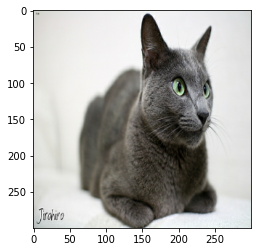

In [ ]:
plt.imshow(x_test[100])

In [ ]:
out=model.predict(np.expand_dims(x_test[100], axis=0))

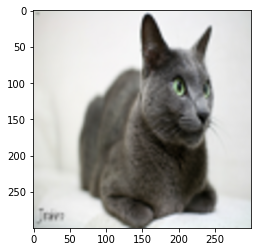

In [ ]:
plt.imshow(prep_image(x_test[100],1))

In [ ]:
out=out/255

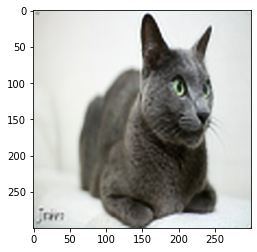

In [ ]:
plt.imshow(out[0])

In [ ]:
tf.image.psnr(out[0], x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=29.184723>

In [ ]:
tf.image.psnr(prep_image(x_test[100],1), x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=28.247568>

In [ ]:
#model.save('SRCNN_weights_bicubic')